In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from src.rover_sim.rover_updated import *
from src.rover_sim.terrain import *

In [3]:
# Set up ALPaCA

%load_ext autoreload
%autoreload 2

# Can change to arbitrary dynamics object, as long as the model being loaded corresponds to it
from src.envs.rocker_bogie_with_terrain_simplified import RockerBogieDynamics as Dynamics
from src.envs.rocker_bogie_with_terrain_simplified import state_space, action_space

from src.models import Alpaca, AlpacaDynamics
from src.models.dataset import DynamicsRandomDataset


In [4]:
# create ground truth dynamics to compare to
dynamics = Dynamics()
dynamics.seed(1234)

c rand
phi rand


[1234]

In [5]:
# Set up ALPaCA dyn_fns

# These params shouldn't change
# Loose Sand parameters
# n = 1.1; k_c = 0.9e3; k_phi = 1523.4e3; k = 0.025; c1 = 0.18; c2 = 0.32 

# Compact sand parameters 
n = 0.47; k_c = 0.9e3; k_phi = 1523.4e3; k = 0.038; c1 = 0.43; c2 = 0.32 

c_placeholder = 0.9e3 
phi_placeholder = np.deg2rad(30) 
terr_params = [c_placeholder, phi_placeholder, n, k, k_c, k_phi, n, c1, c2] 
dt = 0.1

filename = './trained_models/rocker_bogie_alp_alone'
### NO NOMINAL MODEL, ALPaCA alone
alpaca_model_alone = AlpacaDynamics(Alpaca(model_path=filename).float())
dyn_fn_alpaca_alone = alpaca_model_alone.get_model(modeltype=alpaca_model_alone.ModelType.POSTERIOR_PREDICTIVE)

filename = './trained_models/rocker_bogie_alp_nom'
### WITH NOMINAL MODEL broken up (simplified) only velocity
fnom = lambda x,u: dynamics.rover.get_fnom_function_vel_only(x, u, terr_params, dt)
phi_nom_fn=lambda x,u: dynamics.rover.get_c_tanphi_features_matrix_vel_only(x,u, terr_params, dt)
model = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_with_nom = AlpacaDynamics(model, f_nom=fnom)
dyn_fn_alpaca_with_nom = alpaca_model_with_nom.get_model(modeltype=alpaca_model_with_nom.ModelType.POSTERIOR_PREDICTIVE)

filename = './trained_models/rocker_bogie_alp_ortho'
### WITH NOMINAL MODEL broken up (simplified) only velocity - orthogonal loss term
fnom = lambda x,u: dynamics.rover.get_fnom_function_vel_only(x, u, terr_params, dt)
phi_nom_fn=lambda x,u: dynamics.rover.get_c_tanphi_features_matrix_vel_only(x,u, terr_params, dt)
model = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_ortho = AlpacaDynamics(model, f_nom=fnom)
dyn_fn_alpaca_ortho = alpaca_model_ortho.get_model(modeltype=alpaca_model_ortho.ModelType.POSTERIOR_PREDICTIVE)


loading state dict
loading state dict
loading state dict


# Estimate terrain parameters

In [6]:
state_init = np.array([0.0]) # [vel]
prev_slips = np.array([0.001,0.001,0.001])
prev_sinkages = np.array([0.02,0.02,0.02])

dt = 0.1

c_placeholder = 0.9e3 
phi_placeholder = np.deg2rad(30) 
terr_params = [c_placeholder, phi_placeholder, n, k, k_c, k_phi, n, c1, c2] 

In [7]:
fnom = lambda x,u: dynamics.rover.get_fnom_function_vel_only(x, u, terr_params, dt)
phi_nom_fn=lambda x,u: dynamics.rover.get_c_tanphi_features_matrix_vel_only(x,u, terr_params, dt)

In [8]:
def do_estimation_noisy(terr_params_true):
    num_sim_steps = 50
    [_, _, n, k, k_c, k_phi, n, c1, c2] = terr_params_true
    # Loose sand
    # n_lin = 1.0; k_c_lin = 1.1e3; k_phi_lin = 1515e3; k_lin = 0.025; c1_lin = 0.33; c2_lin = 0.32 
    # Compact sand
    n_lin = 0.48; k_c_lin = 0.9e3; k_phi_lin = 1515e3; k_lin = 0.035; c1_lin = 0.42; c2_lin = 0.32 
    # terr_params_for_est = [0, 0, n, k, k_c, k_phi, n, c1, c2]
    terr_params_for_est = [0, 0, n_lin, k_lin, k_c_lin, k_phi_lin, n_lin, c1_lin, c2_lin]

    # alpaca_model_alone.reset()
    alpaca_model_with_nom.reset()
    alpaca_model_ortho.reset()

    torques_list = dynamics.rover.get_random_torques(num_sim_steps, two_phase=True)

    u_list = np.zeros((num_sim_steps, 6))
    x_list = np.zeros((num_sim_steps+1, 1))
    x_curr = state_init
    x_list[0,:] = state_init
    x_noisy_list = np.zeros((num_sim_steps+1, 1))
    x_noisy_list[0,:] = state_init
    u_noisy_list = np.zeros((num_sim_steps, 6))

    true_params_list = np.vstack([c_true*np.ones(num_sim_steps), phi_true*np.ones(num_sim_steps)]).T
    est_params_nom_list = np.zeros((num_sim_steps, 3))

    est_params_fnom_list = np.zeros((num_sim_steps, 2))

    est_params_Iag_list = np.zeros((num_sim_steps, 2))
    est_params_alpaca_list = np.zeros((num_sim_steps, 64))
     
    est_params_alpanom_list = np.zeros((num_sim_steps+1, 2))
    est_var_alpanom_list = np.zeros((num_sim_steps+1, 2, 2))
    stats = alpaca_model_with_nom.model.prior_params()
    Q, L = stats 
    Kbar = (torch.inverse(L) @ Q)
    est_params_alpanom_list[0,:] = Kbar.detach().numpy().squeeze()[...,-2:]
    est_var_alpanom_list[0,:] = L.detach().numpy().squeeze()[...,-2:, -2:]
    
    est_params_alportho_list = np.zeros((num_sim_steps+1, 2))
    est_var_alportho_list = np.zeros((num_sim_steps+1, 2, 2))
    stats = alpaca_model_ortho.model.prior_params()
    Q, L = stats 
    Kbar = (torch.inverse(L) @ Q)
    est_params_alportho_list[0,:] = Kbar.detach().numpy().squeeze()[...,-2:]
    est_var_alportho_list[0,:] = L.detach().numpy().squeeze()[...,-2:, -2:]

    A_list = np.zeros((num_sim_steps,2))
    b_list = np.zeros(num_sim_steps)

    for step in range(num_sim_steps):
        # Simulate a step using true params
        full_action = dynamics.rover.get_full_action_vel_only(x_curr, torques_list[step,:], terr_params_true, prev_slips, prev_sinkages)
        u = full_action[3:9]
        xp = dynamics.rover.transition_vel_only(x_curr, u, terr_params_true, dt)

        x_noise = 0.01
        xp_noisy = xp + x_noise*np.random.randn(*xp.shape)
        u_noise = 0.05
        u_noisy = u + np.abs(u)*u_noise*np.random.randn(*u.shape)

        u_list[step,:] = u # slips, sinkage3
        x_list[step+1,:] = xp
        x_noisy_list[step+1,:] = xp_noisy
        u_noisy_list[step,:] = u_noisy
        
        # Estimate params using linear model on states so far
        # Try a horizon 
        horizon = 4
        if step<horizon:
            est_params_nom = dynamics.rover.estimate_params_lin_model_vel_only(x_list[0:step+2,:], u_list[0:step+1,:], terr_params_for_est, dt)
            est_params_nom_list[step,:] = est_params_nom
        elif step>=horizon:
            est_params_nom = dynamics.rover.estimate_params_lin_model_vel_only(x_list[step+2-horizon-1:step+2,:], u_list[step+1-horizon:step+1,:], terr_params_for_est, dt)
            est_params_nom_list[step,:] = est_params_nom

        # Estimate params using Iagnemma model
        est_params_Iag = dynamics.rover.estimate_params_Iag_vel_only(x_curr, xp, u_list[step,:], dt, terr_params_true) # passing the true params so N and T can accurately be estimated. Does not use c, phi beyond that. 
        est_params_Iag_list[step, :] = est_params_Iag

        # Estimate params using ALPaCA with nominal model
        stats = alpaca_model_with_nom.incorporate_transition(x_curr,u_noisy,xp_noisy)
        # stats = alpaca_model_with_nom.incorporate_transition(x_curr,u,np.random.randn(*xp_noisy.shape))
        Q, L = stats
        Kbar = (torch.inverse(L) @ Q)
        theta_vals =  Kbar.detach().numpy().squeeze()[...,-2:]
        var_vals = L.detach().numpy().squeeze()[...,-2:, -2:]
        est_params_alpanom_list[step+1,:] = theta_vals
        est_var_alpanom_list[step+1,:] = var_vals

        # Estimate params using ALPaCA with ortho model
        stats = alpaca_model_ortho.incorporate_transition(x_curr,u_noisy,xp_noisy)
        Q, L = stats
        Kbar = (torch.inverse(L) @ Q)
        theta_vals =  Kbar.detach().numpy().squeeze()[...,-2:]
        var_vals = L.detach().numpy().squeeze()[...,-2:, -2:]
        est_params_alportho_list[step+1,:] = theta_vals
        est_var_alportho_list[step+1,:] = var_vals

        # Update state and param estimate
        x_curr = xp
    
    return true_params_list, est_params_nom_list, est_params_Iag_list, est_params_alpanom_list, est_var_alpanom_list, est_params_alportho_list, est_var_alportho_list, est_params_fnom_list, u_list

In [9]:
def plot_estimates(true_params_list, est_params_nom_list, est_params_Iag_list, est_params_alpanom_list, est_var_alpanom_list, est_params_alportho_list, est_var_alportho_list, est_params_fnom_list = None):
    num_sim_steps = est_params_nom_list.shape[0]
    times = np.arange(num_sim_steps+1)

    # fig = plt.figure(figsize= plt.figaspect(0.2))
    fig = plt.figure(figsize= (20,5))

    ax1 = fig.add_subplot(131)
    ax1.plot(times[:-1], true_params_list[:,0], label='True')
    ax1.plot(times[:-1], est_params_nom_list[:,0], label ='Estimate (Linear model)')
    ax1.plot(times[:-1], est_params_Iag_list[:,0], label ='Estimate (Iagnemma)')

    ax1.plot(times, 1000*est_params_alpanom_list[:,0], color='C3', label ='Estimate (ALPaCA with linear model)')
    ax1.fill_between(times,1000*(est_params_alpanom_list[:,0] - 1.96/np.sqrt(est_var_alpanom_list[:,0,0])), 1000*(est_params_alpanom_list[:,0] + 1.96/np.sqrt(est_var_alpanom_list[:,0,0])),color='C3', alpha=0.25)

    ax1.plot(times, 1000*est_params_alportho_list[:,0],color='C4',  label ='Estimate (ALPaCA with ortho loss)')
    ax1.fill_between(times,1000*(est_params_alportho_list[:,0] - 1.96/np.sqrt(est_var_alportho_list[:,0,0])), 1000*(est_params_alportho_list[:,0] + 1.96/np.sqrt(est_var_alportho_list[:,0,0])),color='C4',alpha=0.25)
    

    ax1.set(title = 'Cohesion (c)', xlabel = 'Sim time', ylabel = '[Pa]')
    ax1.legend(loc = 'best')
    ax1.grid()

    ax2 = fig.add_subplot(132)
    ax2.plot(times[:-1], true_params_list[:,1]*180/np.pi, label='True')
    ax2.plot(times[:-1], est_params_nom_list[:,1]*180/np.pi, label ='Estimate (Linear model)')
    ax2.plot(times[:-1], est_params_Iag_list[:,1]*180/np.pi, label ='Estimate (Iagnemma)')

    ax2.plot(times, est_params_alpanom_list[:,1]*180/np.pi,color='C3', label ='Estimate (ALPaCA with linear model)')
    ax2.fill_between(times,180/np.pi*(est_params_alpanom_list[:,1] - 1.96/np.sqrt(est_var_alpanom_list[:,1,1])), 180/np.pi*(est_params_alpanom_list[:,1] + 1.96/np.sqrt(est_var_alpanom_list[:,1,1])),color='C3',alpha=0.25)

    ax2.plot(times, est_params_alportho_list[:,1]*180/np.pi,color='C4', label ='Estimate (ALPaCA with ortho loss)')
    ax2.fill_between(times,180/np.pi*(est_params_alportho_list[:,1] - 1.96/np.sqrt(est_var_alportho_list[:,1,1])), 180/np.pi*(est_params_alportho_list[:,1] + 1.96/np.sqrt(est_var_alportho_list[:,1,1])),color='C4',alpha=0.25)

    ax2.set(title = 'Angle of internal friction (phi)', xlabel = 'Sim time', ylabel = '[Deg]')
    ax2.legend(loc = 'best')
    ax2.grid() 
    ax2.set_ylim((0,80))

    plt.show()

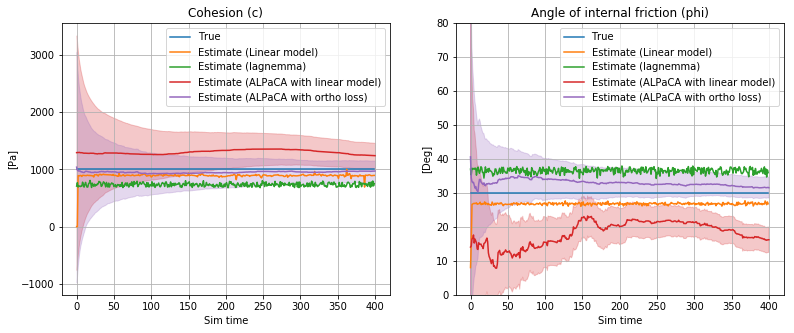

In [10]:
# True parameters
c_true = 0.7e3
phi_true = np.deg2rad(30)
terr_params_true = [c_true, phi_true, n, k, k_c, k_phi, n, c1, c2]

# Do full calc
# true_params_list, est_params_nom_list, est_params_Iag_list, est_params_alpanom_list, est_var_alpanom_list, est_params_alportho_list, est_var_alportho_list, est_params_fnom_list, u_list = do_estimation_noisy(terr_params_true)

# Load in from data for speed
import pickle
filename = './stored_results/results_for_est_param_loose.pickle'
with open(filename, 'rb') as f:
    true_params_list, est_params_nom_list, est_params_Iag_list, est_params_alpanom_list, est_var_alpanom_list, est_params_alportho_list, est_var_alportho_list, est_params_fnom_list, u_list = pickle.load(f)

plot_estimates(true_params_list, est_params_nom_list, est_params_Iag_list, est_params_alpanom_list, est_var_alpanom_list, est_params_alportho_list, est_var_alportho_list, est_params_fnom_list)

